In [1]:
import nltk
from pycocotools.coco import COCO
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

import os
import pickle
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn




# Load Dictionary

In [2]:
class Vocab(object):
    
    def __init__(self):
        self.w2i = {} # word to index
        self.i2w = {}
        self.index = 0
    
    # if v is a Vocab object, v(token) will return the index associated with the token
    def __call__(self,token):
        if not token in self.w2i:
            return self.w2i["<unk>"]
        return self.w2i[token]
    
    def __len__(self):
        return len(self.w2i)
    
    def add_token(self,token):
        if not token in self.w2i:
            # if the token is new, assign an index to it and update w2i, i2w, update index
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1
    
            
        

In [3]:
with open("vocabulary.pkl","rb") as f:
    vocabulary = pickle.load(f)

# Models

In [4]:
class CNN(nn.Module):
    def __init__(self,embedding_size,weight_path):
        # pretrained ResNext-50
        super(CNN,self).__init__()
        resnet = models.resnext50_32x4d(pretrained=False)
        if weight_path:
            resnet.load_state_dict(torch.load(weight_path))
        # exclude the last layer
        module_list = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*module_list) 
        self.linear = nn.Linear(resnet.fc.in_features,embedding_size) # embed the output features
        self.batch_norm = nn.BatchNorm1d(embedding_size,momentum=0.01)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self,input_imgs):
        # extract features
        with torch.no_grad():
            features = self.resnet(input_imgs)
        
        # embed the features
        features = features.reshape(features.size(0),-1)
        features = self.dropout(self.batch_norm(self.linear(features)))
        return features


        
        

In [5]:
class LSTM(nn.Module):
    def __init__(self,embed,hidden,vocab,num_layers,max_seq_len=30):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab,embed)
        self.lstm = nn.LSTM(embed,hidden,num_layers,batch_first=True,dropout=0.1)
        #self.lstm = nn.LSTM(embed*2,hidden,num_layers,batch_first=True,dropout=0.1)
        self.linear = nn.Linear(hidden,vocab)
        self.max_seq_len = max_seq_len
    
    def forward(self,input_features,capts,lens):
        # decode image feature vectors and generate captions
        ####
        capts = capts[:,:-1] # for each caption, ignore the last token
        ###
        
        embeddings = self.embedding(capts)
        # input_features (batch,embed_size)
        # embeddings (batch,sequence_len,embed_size)
        
        #####
        repeated_features = input_features.unsqueeze(1).repeat(1,embeddings.size(dim=1),1)
        embeddings = torch.cat((repeated_features,embeddings),2)
        
        #####
        
        #embeddings = torch.cat((input_features.unsqueeze(1),embeddings), 1)
        #lstm_input = pack_padded_sequence(embeddings, np.array(lens), batch_first=True)
        
        lstm_input = pack_padded_sequence(embeddings, np.array(lens)-1, batch_first=True)
        hidden_variables,_ = self.lstm(lstm_input)
        model_outputs = self.linear(hidden_variables[0])
        return model_outputs
    
    def sample(self,input_features,lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

# load image & model

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.485,0.456,0.406),
                                                   (0.229,0.224,0.225))])
def load_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize([224,224],Image.LANCZOS)
    img = transform(img).unsqueeze(0)
    return img

In [7]:
encoder = CNN(256,None).eval()
decoder = LSTM(256,512,len(vocabulary),1).eval()
encoder = encoder.to("cuda")
decoder = decoder.to("cuda")
encoder.load_state_dict(torch.load("Weights/run-2-encoder.pth"))
decoder.load_state_dict(torch.load("Weights/run-2-decoder.pth"))

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

# Generate captioning

In [11]:
path = "Images/07.jpg"
img = load_image(path)
img = img.to("cuda")
feature = encoder(img)
sampled_indices = decoder.sample(feature)
#print(sampled_indices)
sampled_indices = sampled_indices[0].cpu().numpy()
sampled_indices

array([   1,    4,  115,   41,    4, 1413,   17, 1027,   37,  149,    4,
        872,  873,   13,    2,    2,   13,    2,    2,   13,    2,    2,
         13,    2,    2,   13,    2,    2,   13,    2], dtype=int64)

In [12]:
# convert tokens to text
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == "<end>":
        break
predicted_sentence = " ".join(predicted_caption[1:-1]) 
predicted_sentence

'a man in a suit and tie is holding a cell phone .'

a man in a suit and tie is holding a cell phone .


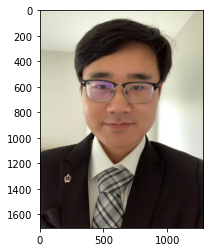

In [13]:
# Print image & generated caption text
print (predicted_sentence)
img = Image.open(path)
plt.imshow(np.asarray(img))